In [1]:
#Import des librairies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import plotly.figure_factory as ff
import plotly.express as px

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import preprocessing , decomposition
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

def plot_dendrogram(Z, names, figsize=(10,25)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    #plt.show()

In [2]:
# Import du fichier csv

pop_alim = pd.read_csv("pop_alim.csv")
pop_alim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 8 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Zone                                                   167 non-null    object 
 1   Pop 2017                                               167 non-null    float64
 2   Disponibilité alimentaire (Kcal/personne/jour)         167 non-null    float64
 3   Disponibilité intérieure                               167 non-null    float64
 4   Exportations - Quantité                                167 non-null    float64
 5   Importations - Quantité                                167 non-null    float64
 6   PIB par habitant                                       167 non-null    float64
 7   Stabilité politique et absence de violence/terrorisme  167 non-null    float64
dtypes: float64(7), object(1)
memory usage: 10.6+ KB


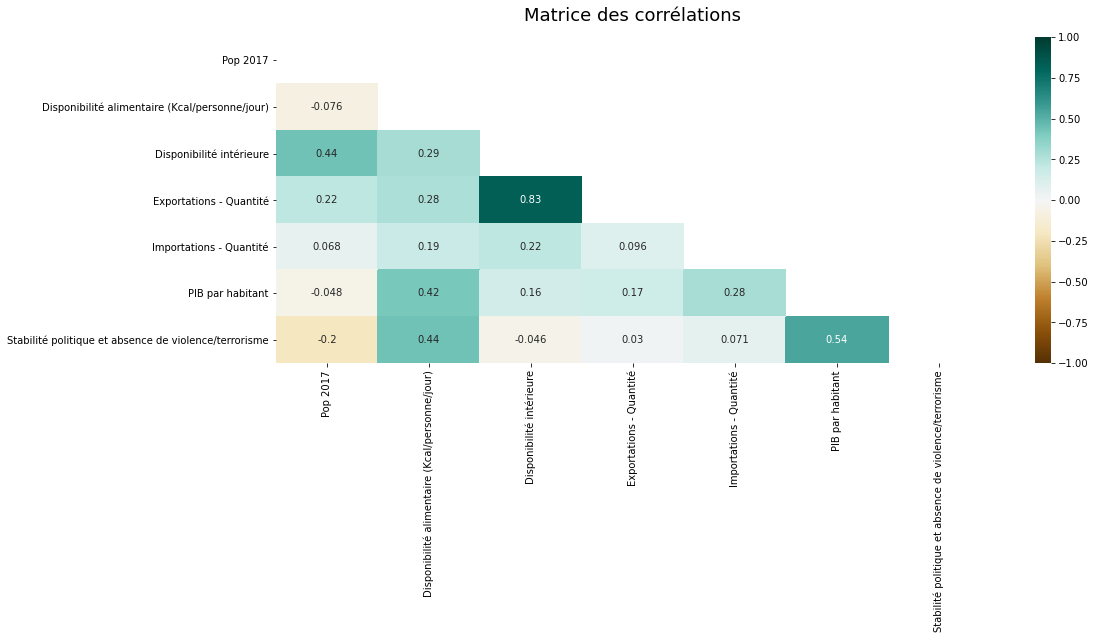

In [3]:
#On regarde la corrélation des données choisies, si elles sont trop corrélées il faut en changer.

corr_df = pop_alim.corr(method='pearson')

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr_df, dtype=bool))
heatmap = sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Matrice des corrélations', fontdict={'fontsize':18}, pad=16);

Les plus fortes corrélations se situent entre 0,4 et 0,8, ce qui est correct , nous pouvons poursuivre l'analyse.

## Classification hierarchique

In [4]:
pop_alim.head()

Zone    Pop 2017  Disponibilité alimentaire (Kcal/personne/jour)  \
0     Afghanistan  36296113.0                                             5.0   
1  Afrique du Sud  57009756.0                                           143.0   
2         Albanie   2884169.0                                            85.0   
3         Algérie  41389189.0                                            22.0   
4       Allemagne  82658409.0                                            71.0   

   Disponibilité intérieure  Exportations - Quantité  Importations - Quantité  \
0                      57.0                      0.0                     29.0   
1                    2118.0                     63.0                    514.0   
2                      47.0                      0.0                     38.0   
3                     277.0                      0.0                      2.0   
4                    1739.0                    646.0                    842.0   

   PIB par habitant  Stabilité politique et absence de violence/terrorisme  
0            2033.8                                              -2.76      
1           13875.9                                              -0.23      
2           13317.1                                               0.37      
3           11630.7                                              -0.84      
4           53486.8                                               0.59

In [5]:
#Indexation selon les pays par la fonction .set_index()
# transformer les données en array numpy
pop_alim.set_index('Zone', inplace=True)
pop_alim2 = pop_alim.values
pop_alim2.shape

(167, 7)

In [6]:
#Standardisation pour mettre toutes les données à la même échelle, sans perte de la variation des données
std_scale = preprocessing.StandardScaler().fit(pop_alim2)
pop_alim2_scaled = std_scale.transform(pop_alim)



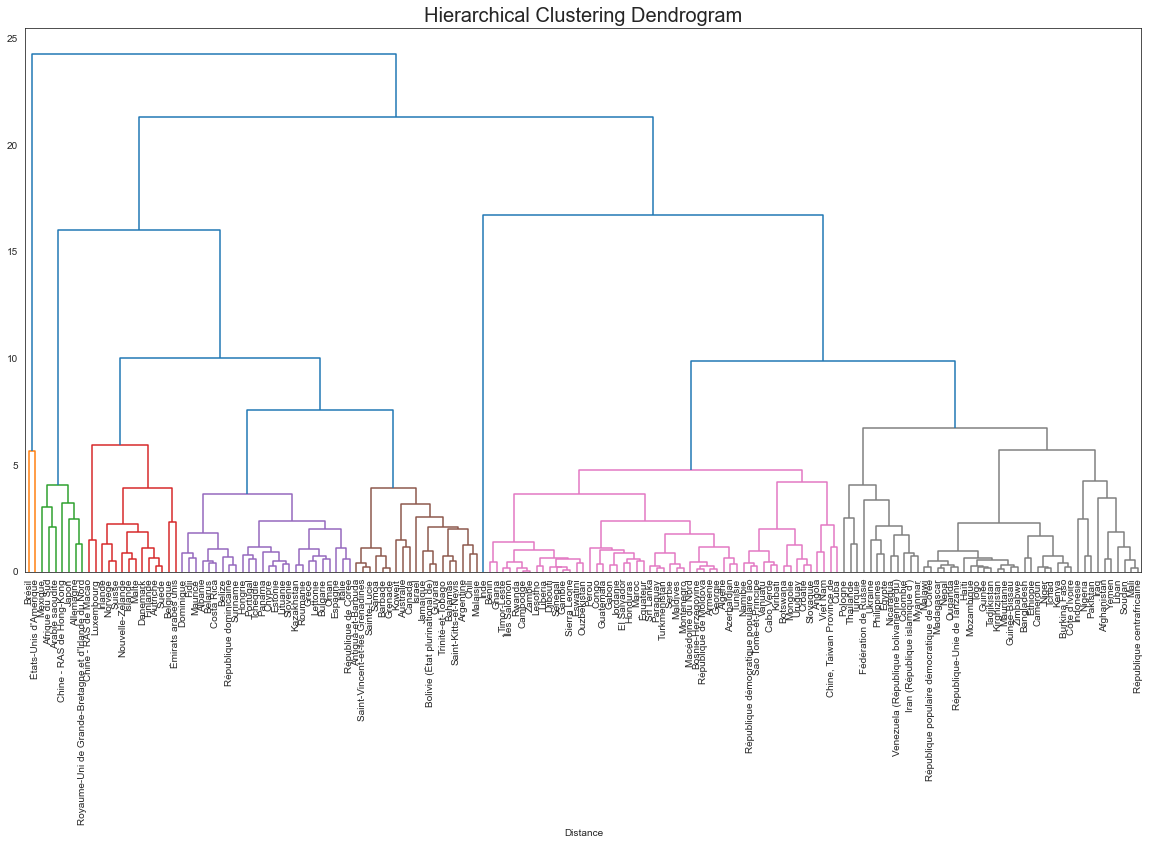

In [7]:
#Affichage d'un premier dendrogramme global
#Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
Z = linkage(pop_alim2_scaled, method = 'ward', metric='euclidean')

fig =plt.figure(figsize=(20,10))
sns.set_style('white')
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Distance')

dendrogram(Z, labels = pop_alim.index, leaf_font_size=10, color_threshold=7, orientation='top')
plt.show()

In [8]:
# Créer un modéle de clustering hierarchique 

hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True) 

In [9]:
# Fit les données au modèle pour voir de quoi se compose chaque cluster:

hiercluster.set_params(n_clusters=6)
clusters = hiercluster.fit_predict(pop_alim2_scaled) 
np.bincount(clusters) # compte le nombre de point de données dans chaque clusters

array([98,  2, 45,  1,  7, 14], dtype=int64)

J'ajoute une nouvelle colonne aux données, le numéro de cluster au df d'origine comme ça je peux voir de quoi il se compose :


In [10]:
# Ajouter le numéro de cluster au df
pop_alim2_scaled_clustered = pd.DataFrame(pop_alim2_scaled, columns=pop_alim.columns, index=pop_alim.index)
pop_alim2_scaled_clustered['cluster'] = clusters

pop_alim2_scaled_clustered.head()

Pop 2017  Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                                       
Afghanistan     0.010492                                       -1.131896   
Afrique du Sud  0.195553                                        1.143348   
Albanie        -0.288021                                        0.187086   
Algérie         0.055995                                       -0.851612   
Allemagne       0.424706                                       -0.043736   

                Disponibilité intérieure  Exportations - Quantité  \
Zone                                                                
Afghanistan                    -0.301805                -0.204532   
Afrique du Sud                  0.888904                -0.064344   
Albanie                        -0.307583                -0.204532   
Algérie                        -0.174704                -0.204532   
Allemagne                       0.669943                 1.232948   

                Importations - Quantité  PIB par habitant  \
Zone                                                        
Afghanistan                   -0.295110         -0.843935   
Afrique du Sud                 2.425093         -0.281664   
Albanie                       -0.244632         -0.308196   
Algérie                       -0.446544         -0.388267   
Allemagne                      4.264736          1.599090   

                Stabilité politique et absence de violence/terrorisme  cluster  
Zone                                                                            
Afghanistan                                             -2.967003            0  
Afrique du Sud                                          -0.166814            4  
Albanie                                                  0.497262            2  
Algérie                                                 -0.841959            0  
Allemagne                                                0.740757            4

In [11]:
# voir la taille de chaque cluster
pop_alim2_scaled_clustered["cluster"].value_counts()

0    98
2    45
5    14
4     7
1     2
3     1
Name: cluster, dtype: int64

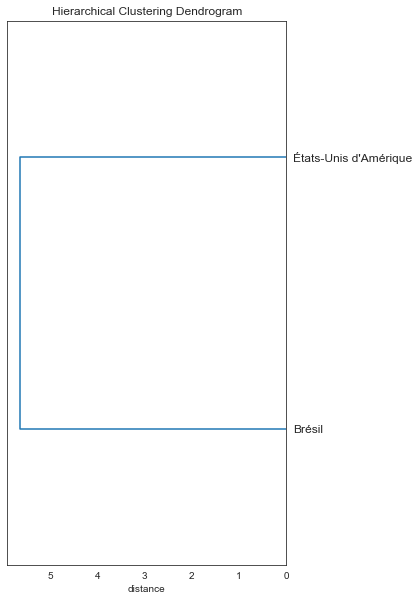

In [12]:
# Dendrogramme pour le plus petit cluster

sample = pop_alim2_scaled_clustered[pop_alim2_scaled_clustered.cluster==1]
Z = linkage(sample, 'ward') 
names = sample.index 
plot_dendrogram(Z, names, figsize=(5,10))

In [13]:
#Composition du nouveau df
pop_alim2_scaled_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Îles Salomon
Data columns (total 8 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Pop 2017                                               167 non-null    float64
 1   Disponibilité alimentaire (Kcal/personne/jour)         167 non-null    float64
 2   Disponibilité intérieure                               167 non-null    float64
 3   Exportations - Quantité                                167 non-null    float64
 4   Importations - Quantité                                167 non-null    float64
 5   PIB par habitant                                       167 non-null    float64
 6   Stabilité politique et absence de violence/terrorisme  167 non-null    float64
 7   cluster                                                167 non-null    int64  
dtypes: float64(7), int64(1)
memory usage:

In [14]:
#Mapping des clusters obtenus:
px.choropleth(pop_alim2_scaled_clustered, locations=pop_alim2_scaled_clustered.index, range_color = (0,30),
                    color="cluster",
                    hover_name=pop_alim2_scaled_clustered.index,
                    color_discrete_sequence=px.colors.qualitative.Set2,
                    
                    title= "Répartition géographiques des clusters obtenus par classification ascendante hiérarchique"
)


[Text(0.5, 34.0, 'Variables'), Text(124.0, 0.5, 'Clusters')]

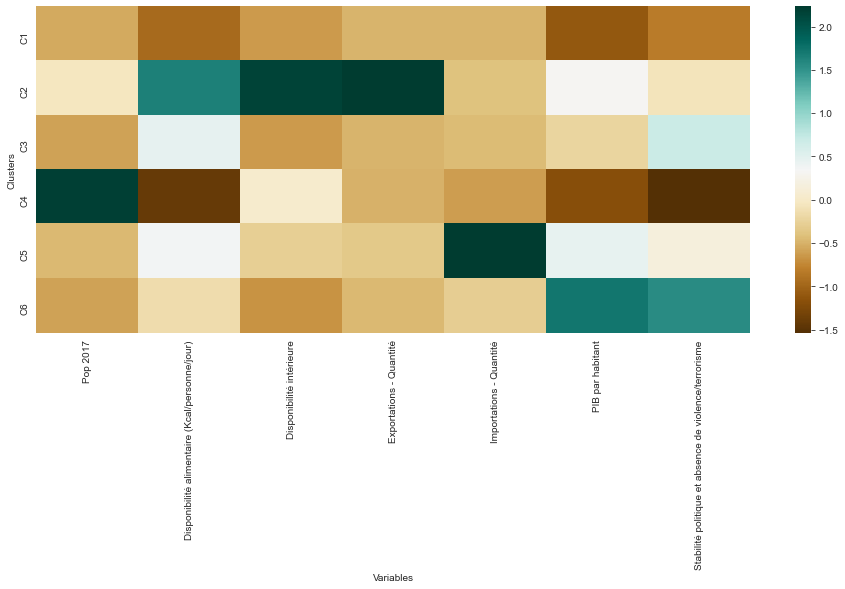

In [15]:
# heatmap de la classification ascendante hierarchique pour voir les differentes tendances de nos clusters

pop_alim_heatmap = pop_alim.groupby(pop_alim2_scaled_clustered['cluster']).mean()
pop_alim_heatmap = pop_alim_heatmap[['Pop 2017','Disponibilité alimentaire (Kcal/personne/jour)','Disponibilité intérieure','Exportations - Quantité','Importations - Quantité','PIB par habitant','Stabilité politique et absence de violence/terrorisme']]
X2 = pop_alim_heatmap.values
names2 = pop_alim_heatmap.index
features2 = pop_alim_heatmap.columns

# Centrage et Réduction
std_scale2 = preprocessing.StandardScaler().fit(X2)
X_scaled2 = std_scale2.transform(X2)
X_scaled2 = pd.DataFrame(X_scaled2)
X_scaled2.columns = list(features2)
clusterslabel = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
plt.figure(figsize=(16, 6))
p = sns.heatmap(X_scaled2, cmap='BrBG', yticklabels=clusterslabel)
p.set(xlabel= "Variables", ylabel= 'Clusters')

heatmap utilise la couleur comme echelle de mesure, la couleur plus foncée represente les valeurs les plus elevées et les couleurs claires les valeurs les plus basses.
On voit ici la confirmation qu'il ya 6 clusters comme vu précédemment.

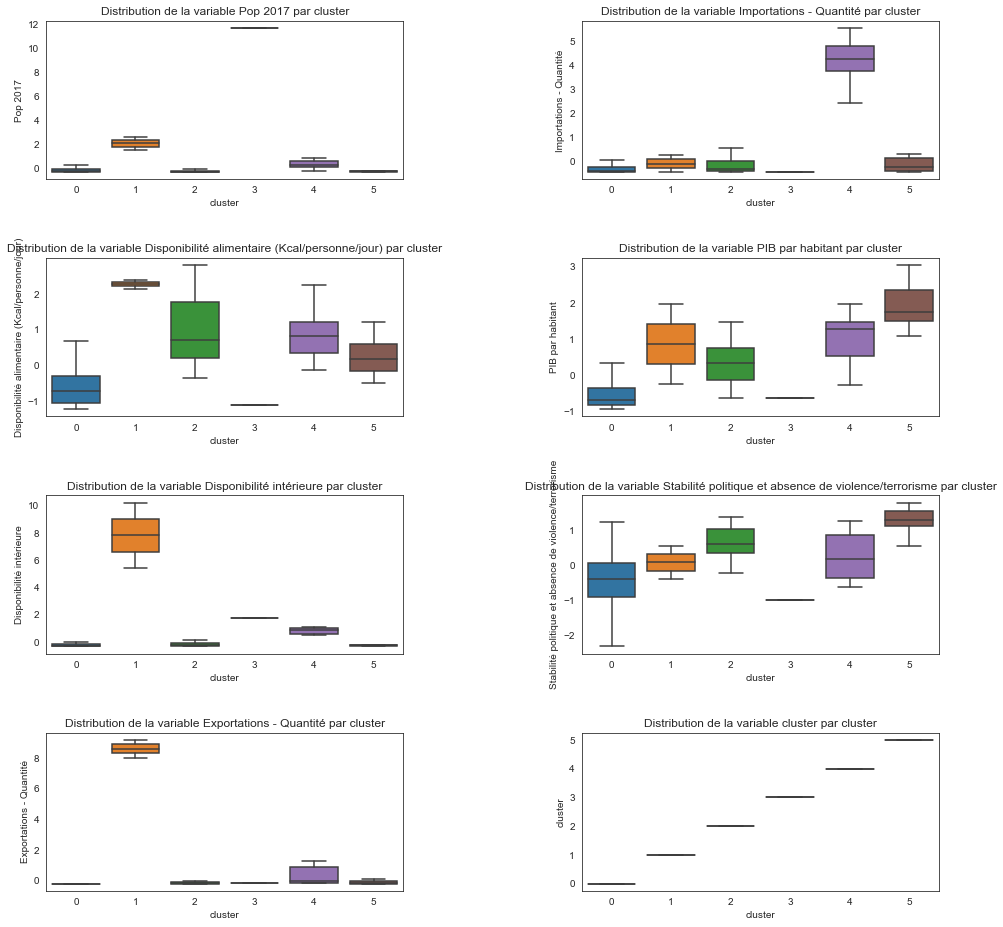

In [16]:
# On regarde la repartition par cluster

n=len(pop_alim2_scaled_clustered.columns)
j = 0
k = 0
fig,ax = plt.subplots(int(n/2),2, figsize=(n*2,n*2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
for i in range(n):
    if i < n/2 :
        j = 0
        k = i
    else :
        j = 1
        k = i - int((n / 2))
    plt.sca(ax[k,j])
    col = pop_alim2_scaled_clustered.columns[i]
    sns.boxplot(data=pop_alim2_scaled_clustered, x="cluster", y=col, showfliers = False).set_title("Distribution de la variable {} par cluster".format(col))

Boxplot, represente la rang des interquartile et les traits exterieurs  montre la rang de notre donnée, le trait du milieu represente la mediane des valeurs.

Le clusters 0, présente une petite population, importe peu. Et a peu de disponibilité alimentaire par habitant. Ainsi qu'un petit PIB. La stabilité politique est faible (Valeur négative et médiane négative). 

Le cluster 1, a une population importante. Une importation assez moyenne avec une répartition symétrique. Il a une bonne disponibilité alimentaire par habitant. Et est l'un des PIB par habitant le plus élevé. Ainsi que la disponibilité intérieure par habitant la plus élevée. C'est l'un des clusters de notre groupe relativement stable politiquement. C'est aussi l'exportation la plus élevée. 

Le cluster 2, présente une distribution asymétrique dans l'importation. Mais il a une bonne stabilité politique. C'est l'une des plus élevées. La disponibilité alimentaire par habitant a une médiane basse mais a une grande répartition.

Le cluster 3. Présente la population la plus importante des clusters. Mais très peu d'importation. Il a aussi la disponibilité alimentaire par habitant et le PIB par habitant le plus faible des clusters ainsi que la stabilité politique la plus faible.

Le cluster 4. À une population assez importante. Mais il importe beaucoup, c'est le plus élevé des clusters. Il a une bonne disponibilité alimentaire par habitant. Ainsi que le PIB par habitant a une médiane haute. Et une bonne stabilité politique.

Le cluster 5. Il présente une bonne disponibilité alimentaire. Et à le PIB par habitant et la stabilité et la politique. La plus élevée de notre groupe.


Selon notre classification hiérarchique, le cluster le plus pertinent semble être le Cluster 5 mais le cluster 4 semble aussi interessant mais sa forte dependance à l'importation peut être un frein.
Regardons de quoi ils se composent : 

In [17]:
cluster_5_cah = pop_alim2_scaled_clustered.loc[pop_alim2_scaled_clustered['cluster'] == 5]
cluster_5_cah

Pop 2017  \
Zone                             
Autriche             -0.234989   
Belgique             -0.211761   
Chine - RAS de Macao -0.308226   
Danemark             -0.262575   
Finlande             -0.264548   
Irlande              -0.271321   
Islande              -0.310801   
Luxembourg           -0.308500   
Malte                -0.309876   
Norvège              -0.266470   
Nouvelle-Zélande     -0.271779   
Suisse               -0.238242   
Suède                -0.225295   
Émirats arabes unis  -0.229027   

                      Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                                   
Autriche                                                   -0.142659   
Belgique                                                   -0.488892   
Chine - RAS de Macao                                        1.126861   
Danemark                                                    0.632243   
Finlande                                                   -0.093198   
Irlande                                                     0.434395   
Islande                                                     0.500344   
Luxembourg                                                 -0.076710   
Malte                                                       0.483857   
Norvège                                                    -0.126172   
Nouvelle-Zélande                                            1.093886   
Suisse                                                     -0.307532   
Suède                                                      -0.208608   
Émirats arabes unis                                         1.209297   

                      Disponibilité intérieure  Exportations - Quantité  \
Zone                                                                      
Autriche                             -0.234788                -0.030966   
Belgique                             -0.246921                 1.255200   
Chine - RAS de Macao                 -0.323759                -0.204532   
Danemark                             -0.238255                 0.104771   
Finlande                             -0.270608                -0.177830   
Irlande                              -0.260786                 0.002412   
Islande                              -0.328959                -0.204532   
Luxembourg                           -0.328381                -0.202307   
Malte                                -0.326648                -0.204532   
Norvège                              -0.275807                -0.204532   
Nouvelle-Zélande                     -0.237677                -0.153352   
Suisse                               -0.257898                -0.195631   
Suède                                -0.226700                -0.153352   
Émirats arabes unis                  -0.096710                 0.004637   

                      Importations - Quantité  PIB par habitant  \
Zone                                                              
Autriche                             0.159192          1.683207   
Belgique                             1.437968          1.487620   
Chine - RAS de Macao                -0.328762          5.344711   
Danemark                             0.288191          1.726908   
Finlande                            -0.368023          1.340928   
Irlande                              0.097497          3.034888   
Islande                             -0.446544          1.757267   
Luxembourg                          -0.396066          4.522155   
Malte                               -0.407283          1.177272   
Norvège                             -0.446544          2.114470   
Nouvelle-Zélande                    -0.452153          1.094622   
Suisse                              -0.171719          2.411509   
Suède                                0.013367          1.545081   
Émirats arabes unis                  1.970791          2.239197   

                      Stabilité politique et absen

In [18]:
cluster_4_cah = pop_alim2_scaled_clustered.loc[pop_alim2_scaled_clustered['cluster'] == 4]
cluster_4_cah

Pop 2017  \
Zone                                                           
Afrique du Sud                                      0.195553   
Allemagne                                           0.424706   
Arabie saoudite                                    -0.018053   
Chine - RAS de Hong-Kong                           -0.248512   
Japon                                               0.825358   
Mexique                                             0.801009   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...  0.282374   

                                                    Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                                                                 
Afrique du Sud                                                                            1.143348   
Allemagne                                                                                -0.043736   
Arabie saoudite                                                                           1.275246   
Chine - RAS de Hong-Kong                                                                  2.247996   
Japon                                                                                    -0.109685   
Mexique                                                                                   0.813603   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                        0.764141   

                                                    Disponibilité intérieure  \
Zone                                                                           
Afrique du Sud                                                      0.888904   
Allemagne                                                           0.669943   
Arabie saoudite                                                     0.494312   
Chine - RAS de Hong-Kong                                           -0.172971   
Japon                                                               1.060491   
Mexique                                                             2.102722   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                  0.955921   

                                                    Exportations - Quantité  \
Zone                                                                          
Afrique du Sud                                                    -0.064344   
Allemagne                                                          1.232948   
Arabie saoudite                                                   -0.182280   
Chine - RAS de Hong-Kong                                           1.270777   
Japon                                                             -0.182280   
Mexique                                                           -0.184505   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                 0.594315   

                                                    Importations - Quantité  \
Zone                                                                          
Afrique du Sud                                                     2.425093   
Allemagne                                                          4.264736   
Arabie saoudite                                                    3.591696   
Chine - RAS de Hong-Kong                                           4.629299   
Japon                                                              5.537903   
Mexique                                                            4.993862   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                 3.911390   

                                                    PIB par habitant  \
Zone                                                                   
Afrique du Sud                                             -0.281664   
Allemagne                                                   1.599090   
Arabie saoudite                                             1.321005   
Chine - RAS de Hong-Kong                           

In [19]:
cluster_1_cah = pop_alim2_scaled_clustered.loc[pop_alim2_scaled_clustered['cluster'] == 1]
cluster_1_cah

Pop 2017  \
Zone                              
Brésil                 1.543060   
États-Unis d'Amérique  2.590614   

                       Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                                    
Brésil                                                       2.149072   
États-Unis d'Amérique                                        2.396381   

                       Disponibilité intérieure  Exportations - Quantité  \
Zone                                                                       
Brésil                                 5.432202                 9.192494   
États-Unis d'Amérique                 10.218148                 8.010912   

                       Importations - Quantité  PIB par habitant  \
Zone                                                               
Brésil                               -0.440935         -0.244040   
États-Unis d'Amérique                 0.232105          1.971956   

                       Stabilité politique et absence de violence/terrorisme  \
Zone                                                                           
Brésil                                                         -0.399241       
États-Unis d'Amérique                                           0.552602       

                       cluster  
Zone                            
Brésil                       1  
États-Unis d'Amérique        1

Conclusion

Il apparait important de noter que la distance à la France n'est pas prise en compte dans ce calcul, on peut faire une priorité vers les pays européens ou proche de la France pour le coût et les contraintes liées au transport. 

Le choix se porterait donc sur : 

- La Belgique

- L' Allemagne

- Le Luxembourg

- Le Royaume-Uni

- La Suisse

## Classification par KMeans :

##### Réalisation d'un clustering K-means

Afin de trouver le bon nombre de clusters à afficher pour l'algorithme KMeans, on peut identifier le nombre de clusters pour lequel l'inertie intra-classe sera minimisée. On peut alors visualiser ces données et sélectionner le nombre optimal de classes dans notre cas.

C:\Users\Juliette\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



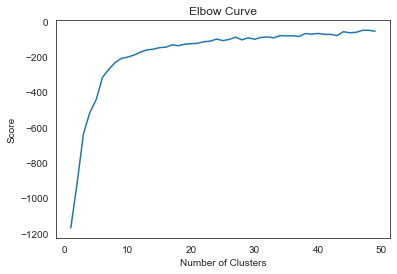

In [20]:
# Run a number of tests, for 1, 2, ... num_clusters
#n_cluster pour connaître le nombre de cluster dont nous avons besoin
num_clusters = 50
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)] 
score = [kmeans_tests[i].fit(pop_alim2_scaled).score(pop_alim2_scaled) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [21]:
inertia = []

In [22]:
k_list = range(1, 10)
list(k_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [23]:
for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(pop_alim2_scaled) 
  inertia.append(kmeans.inertia_)

C:\Users\Juliette\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [24]:
inertia

[1169.0,
 874.6286859073052,
 635.6508186971629,
 496.0360409551704,
 369.4675238050599,
 313.7342934568788,
 259.8799615679228,
 231.60921079826684,
 212.35123338374987]

In [25]:
kmeans.inertia_

212.35123338374987

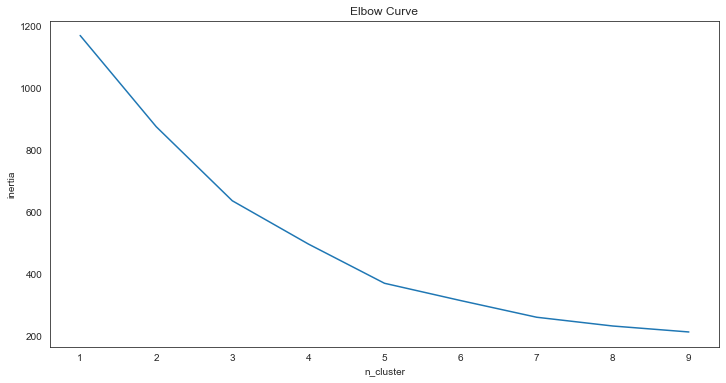

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("inertia")
ax.set_xlabel("n_cluster")
plt.title('Elbow Curve')
ax = plt.plot(k_list, inertia)

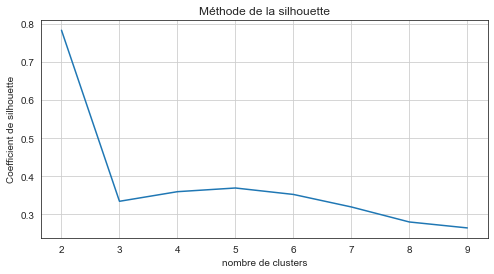

[0.7833012545680146,
 0.3343560110246519,
 0.35957643187352345,
 0.3692436541580162,
 0.35235156970428033,
 0.31948217388021843,
 0.2800726725544502,
 0.2644763970778619]

In [27]:
from sklearn.metrics import silhouette_score
tab_silhouette =[]
k_range=range(2,10)
for k in k_range:
    model=KMeans(n_clusters=k)
    cluster_labels=model.fit_predict(pop_alim2_scaled)
    tab_silhouette.append(silhouette_score(pop_alim2_scaled,cluster_labels))

fig = plt.figure(figsize=(8,4))
plt.plot(k_range,tab_silhouette)
plt.xlabel('nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.title('Méthode de la silhouette')
plt.grid()
plt.show()
tab_silhouette

On utilise la méthode du coude pour nous donner une idée de combien de cluster nous devons séléctionner. 
L'indice du nombre à prendre apparait dès que la courbure se présente sur le graphique.

C:\Users\Juliette\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



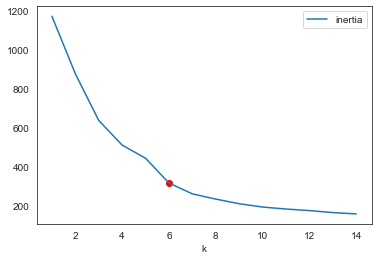

In [28]:
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters = k, init = "random", n_init = 20).fit(pop_alim2_scaled) #n_cluster pour connaître le nombre de cluster dont nous avons besoin
    inertia = inertia + [kmeans.inertia_]
inertia = pd.DataFrame({"k": range(1, 15), "inertia": inertia})
inertia.plot.line(x = "k", y = "inertia")
plt.scatter(6, inertia.query('k == 6')["inertia"], c = "red")
plt.show()

Le nombre de cluster que nous devons prendre se situe à 6 , et est symbolisé par le point rouge sur le graphique

In [29]:
# Create a k-means clustering model
kmeans = KMeans(init='random', n_clusters=5, n_init=10)

# Fit the data to the model
kmeans.fit(pop_alim2_scaled)

# Determine which clusters each data point belongs to:
clusters2 =  kmeans.predict(pop_alim2_scaled)
clusters2

array([1, 4, 3, 1, 4, 1, 3, 4, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 2,
       3, 1, 3, 1, 3, 1, 1, 3, 3, 4, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3,
       1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 0, 1,
       1, 1, 3, 3, 3, 3, 3, 4, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1,
       3, 1, 1, 1, 3, 1, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1,
       1, 1, 3, 1, 1, 3, 3, 1, 3, 4, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3,
       1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1])

In [30]:
labels=kmeans.labels_
labels

array([1, 4, 3, 1, 4, 1, 3, 4, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 2,
       3, 1, 3, 1, 3, 1, 1, 3, 3, 4, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3,
       1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 0, 1,
       1, 1, 3, 3, 3, 3, 3, 4, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1,
       3, 1, 1, 1, 3, 1, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1,
       1, 1, 3, 1, 1, 3, 3, 1, 3, 4, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3,
       1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1])

In [31]:
centroids = kmeans.cluster_centers_
centroids

array([[11.64634078, -1.09892146,  1.78034693, -0.19563118, -0.45776119,
        -0.63121205, -1.00797784],
       [-0.0348866 , -0.61810227, -0.13909792, -0.16234991, -0.23865743,
        -0.57193485, -0.5997874 ],
       [ 2.06683656,  2.27272674,  7.82517461,  8.60170277, -0.10441523,
         0.86395814,  0.07668028],
       [-0.22818523,  0.72060416, -0.16462967, -0.07126328, -0.13596397,
         0.66178257,  0.83518004],
       [ 0.25417599,  0.91252637,  0.73782647,  0.31115845,  3.91559618,
         1.14590221,  0.32294194]])

In [32]:
# Add cluster number to the original data
pop_alim2_scaled_clustered2 = pd.DataFrame(pop_alim2_scaled, columns=pop_alim.columns, index=pop_alim.index)
pop_alim2_scaled_clustered2['cluster'] = clusters2

pop_alim2_scaled_clustered2.head()

Pop 2017  Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                                       
Afghanistan     0.010492                                       -1.131896   
Afrique du Sud  0.195553                                        1.143348   
Albanie        -0.288021                                        0.187086   
Algérie         0.055995                                       -0.851612   
Allemagne       0.424706                                       -0.043736   

                Disponibilité intérieure  Exportations - Quantité  \
Zone                                                                
Afghanistan                    -0.301805                -0.204532   
Afrique du Sud                  0.888904                -0.064344   
Albanie                        -0.307583                -0.204532   
Algérie                        -0.174704                -0.204532   
Allemagne                       0.669943                 1.232948   

                Importations - Quantité  PIB par habitant  \
Zone                                                        
Afghanistan                   -0.295110         -0.843935   
Afrique du Sud                 2.425093         -0.281664   
Albanie                       -0.244632         -0.308196   
Algérie                       -0.446544         -0.388267   
Allemagne                      4.264736          1.599090   

                Stabilité politique et absence de violence/terrorisme  cluster  
Zone                                                                            
Afghanistan                                             -2.967003            1  
Afrique du Sud                                          -0.166814            4  
Albanie                                                  0.497262            3  
Algérie                                                 -0.841959            1  
Allemagne                                                0.740757            4

In [33]:
def display_factorial_planes(pop_alim2_scaled, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(pop_alim2_scaled[:, d1], pop_alim2_scaled[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(pop_alim2_scaled[selected, d1], pop_alim2_scaled[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(pop_alim2_scaled[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(pop_alim2_scaled[:, [d1,d2]])) * 1.1
            plt.xlim([-5,5])
            plt.ylim([-5,5])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

[Text(0.5, 34.0, 'Variables'), Text(124.0, 0.5, 'Clusters')]

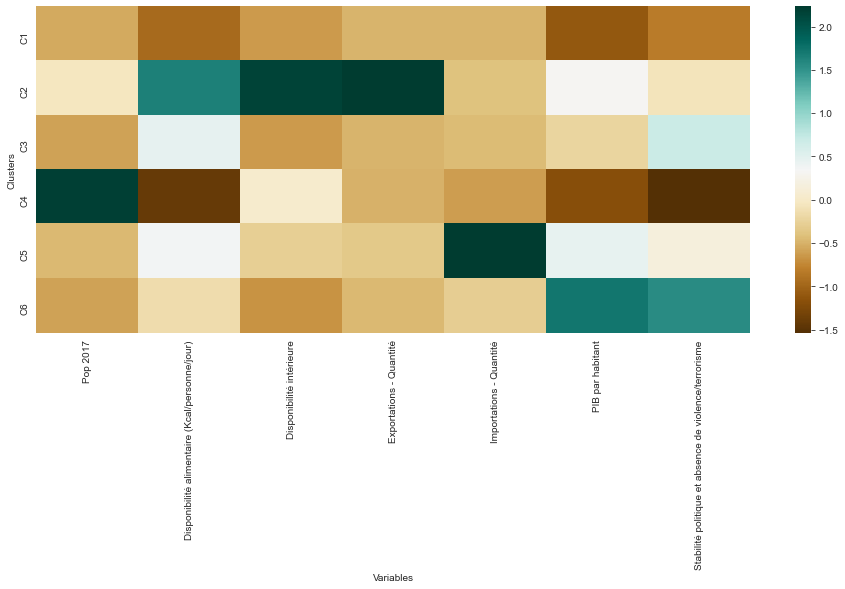

In [34]:
#Heatmap kmeans
pop_alim_heatmap2 = pop_alim.groupby(pop_alim2_scaled_clustered2['cluster']).mean()
pop_alim_heatmap2 = pop_alim_heatmap2[['Pop 2017','Disponibilité alimentaire (Kcal/personne/jour)','Disponibilité intérieure','Exportations - Quantité','Importations - Quantité','PIB par habitant','Stabilité politique et absence de violence/terrorisme']]
X3 = pop_alim_heatmap2.values
names3 = pop_alim_heatmap2.index
features3 = pop_alim_heatmap2.columns

# Centrage et Réduction
std_scale3 = preprocessing.StandardScaler().fit(X3)
X_scaled3 = std_scale2.transform(X3)
X_scaled3 = pd.DataFrame(X_scaled3)
X_scaled3.columns = list(features3)
clusterslabel = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
plt.figure(figsize=(16, 6))
p = sns.heatmap(X_scaled2, cmap='BrBG', yticklabels=clusterslabel)
p.set(xlabel= "Variables", ylabel= 'Clusters')

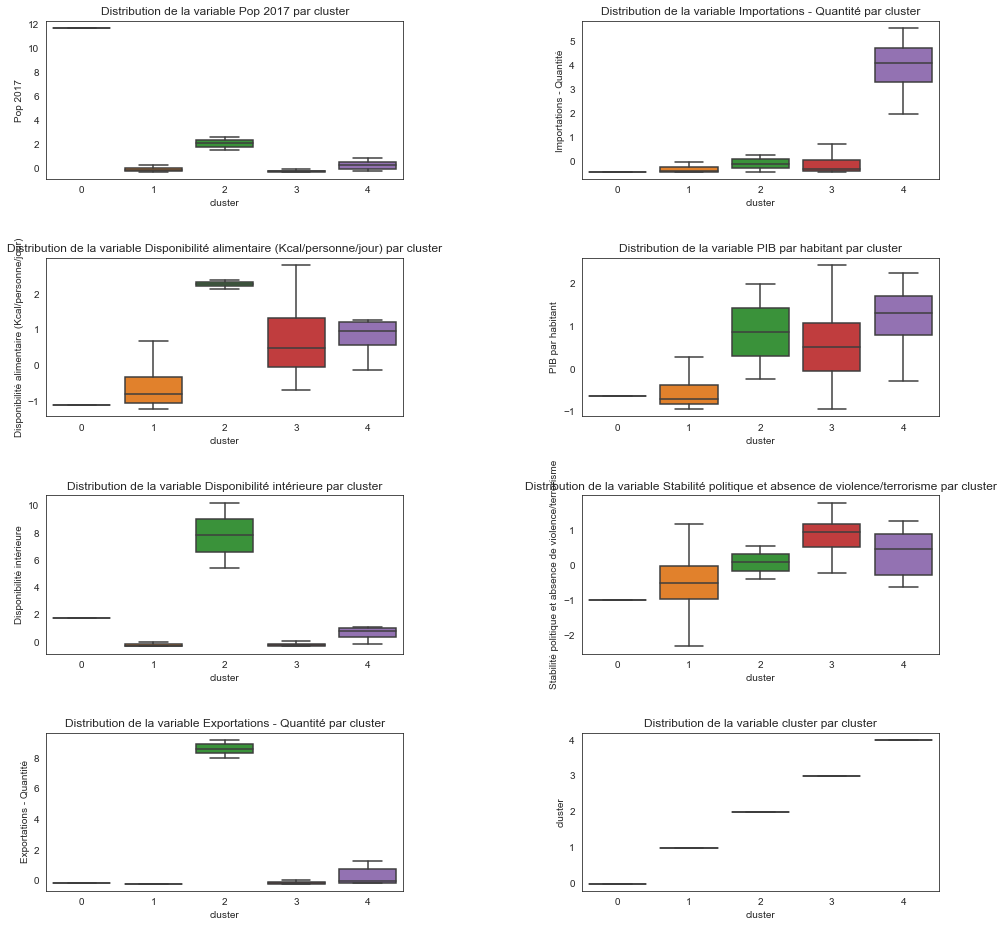

In [35]:
# On regarde la repartition par cluster

n=len(pop_alim2_scaled_clustered2.columns)
j = 0
k = 0
fig,ax = plt.subplots(int(n/2),2, figsize=(n*2,n*2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
for i in range(n):
    if i < n/2 :
        j = 0
        k = i
    else :
        j = 1
        k = i - int((n / 2))
    plt.sca(ax[k,j])
    col = pop_alim2_scaled_clustered2.columns[i]
    sns.boxplot(data=pop_alim2_scaled_clustered2, x="cluster", y=col, showfliers = False).set_title("Distribution de la variable {} par cluster".format(col))

le cluster 0 présente une grande asymétrie dans la répartition de la population. Peu de disponibilité alimentaire et de disponibilité interieure. PIB par habitant, faible et pas de stabilité politique. 

Le cluster 1, a une disponibilité alimentaire et un PIB par habitant plutôt faible. La disponibilité intérieure est très faible et les pays du cluster sont très peu stable politiquement.

Le cluster 2 présente une population importante et la disponibilité alimentaire par habitant la plus importante. Le PIB par habitant est important et équitablement réparti.

Le cluster 3 présente la plus grande disponibilité alimentaire par habitant ainsi que la plus importante stabilité politique des clusters. Le PIB le plus etendu. 

Le cluster 4, a la plus importante disponibilité alimentaire et le PIB le plus élevé. Il a aussi une bonne stabilité politique.

Les clusters 3 et 4 semblent se detacher, affichons les pour voir de quoi ils se composent.

In [36]:
cluster_3_kmeans = pop_alim2_scaled_clustered2.loc[pop_alim2_scaled_clustered2['cluster'] == 3]
cluster_3_kmeans

Pop 2017  Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                                           
Albanie            -0.288021                                        0.187086   
Antigua-et-Barbuda -0.312936                                        2.627203   
Argentine           0.078759                                        1.786352   
Australie          -0.094142                                        1.951225   
Autriche           -0.234989                                       -0.142659   
...                      ...                                             ...   
Suriname           -0.308692                                        0.632243   
Suède              -0.225295                                       -0.208608   
Tchéquie           -0.218718                                        0.137624   
Trinité-et-Tobago  -0.301423                                        1.901763   
Uruguay            -0.283085                                       -0.670252   

                    Disponibilité intérieure  Exportations - Quantité  \
Zone                                                                    
Albanie                            -0.307583                -0.204532   
Antigua-et-Barbuda                 -0.330692                -0.204532   
Argentine                           0.798777                 0.256085   
Australie                           0.341790                -0.111074   
Autriche                           -0.234788                -0.030966   
...                                      ...                      ...   
Suriname                           -0.320293                -0.193406   
Suède                              -0.226700                -0.153352   
Tchéquie                           -0.190880                -0.144452   
Trinité-et-Tobago                  -0.290828                -0.204532   
Uruguay                            -0.315671                -0.197856   

                    Importations - Quantité  PIB par habitant  \
Zone                                                            
Albanie                           -0.244632         -0.308196   
Antigua-et-Barbuda                -0.418501          0.057415   
Argentine                         -0.412892          0.139552   
Australie                         -0.368023          1.387435   
Autriche                           0.159192          1.683207   
...                                     ...               ...   
Suriname                          -0.356805         -0.038097   
Suède                              0.013367          1.545081   
Tchéquie                           0.192844          0.955546   
Trinité-et-Tobago                 -0.328762          0.340172   
Uruguay                           -0.440935          0.153222   

                    Stabilité politique et absence de violence/terrorisme  \
Zone                                                                        
Albanie                                                      0.497262       
Antigua-et-Barbuda                                           1.017455       
Argentine                                                    0.098816       
Australie                                                    1.183474       
Autriche                                                     1.083863       
...                                                               ...       
Suriname                                                     0.165224       
Suède                                                        1.128135       
Tchéquie                                                     1.227746       
Trinité-et-Tobago                                            0.353379       
Uruguay                                                      1.227746       

                    cluster  
Zone                         
Albanie                   3  
Antigua-et-Barbuda        3  
Argentine                 3  
Australie                 3  
A

In [37]:
cluster_4_kmeans = pop_alim2_scaled_clustered2.loc[pop_alim2_scaled_clustered2['cluster'] == 4]
cluster_4_kmeans

Pop 2017  \
Zone                                                           
Afrique du Sud                                      0.195553   
Allemagne                                           0.424706   
Arabie saoudite                                    -0.018053   
Chine - RAS de Hong-Kong                           -0.248512   
Japon                                               0.825358   
Mexique                                             0.801009   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...  0.282374   
Émirats arabes unis                                -0.229027   

                                                    Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                                                                 
Afrique du Sud                                                                            1.143348   
Allemagne                                                                                -0.043736   
Arabie saoudite                                                                           1.275246   
Chine - RAS de Hong-Kong                                                                  2.247996   
Japon                                                                                    -0.109685   
Mexique                                                                                   0.813603   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                        0.764141   
Émirats arabes unis                                                                       1.209297   

                                                    Disponibilité intérieure  \
Zone                                                                           
Afrique du Sud                                                      0.888904   
Allemagne                                                           0.669943   
Arabie saoudite                                                     0.494312   
Chine - RAS de Hong-Kong                                           -0.172971   
Japon                                                               1.060491   
Mexique                                                             2.102722   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                  0.955921   
Émirats arabes unis                                                -0.096710   

                                                    Exportations - Quantité  \
Zone                                                                          
Afrique du Sud                                                    -0.064344   
Allemagne                                                          1.232948   
Arabie saoudite                                                   -0.182280   
Chine - RAS de Hong-Kong                                           1.270777   
Japon                                                             -0.182280   
Mexique                                                           -0.184505   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                 0.594315   
Émirats arabes unis                                                0.004637   

                                                    Importations - Quantité  \
Zone                                                                          
Afrique du Sud                                                     2.425093   
Allemagne                                                          4.264736   
Arabie saoudite                                                    3.591696   
Chine - RAS de Hong-Kong                                           4.629299   
Japon                                                              5.537903   
Mexique                                                            4.993862   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                 3.911390   
Émirats arabes unis                                                1.970791   

       

Toujours dans notre logique de rester proche de la France, plusieurs pays peuvent être compatible tel que : 
- La Belgique
- L'Autriche
- L' Allemagne
- L'Espagne 
- L'Italie

- Le Luxembourg
- Le Portugal

- Le Royaume-Uni

- La Suisse

Text(0.5, 1.0, 'Heatmap sur les centroïdes de K-means')

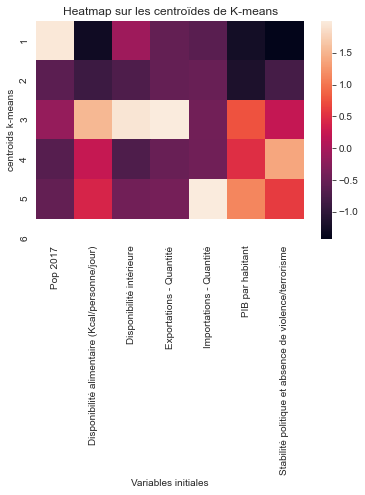

In [38]:
#Heatmap sur les centroides de k-means:

# Centrage et reduction:
centroid_std_scale = preprocessing.StandardScaler().fit(centroids)
centroids_scaled = centroid_std_scale.transform(centroids)

sns.heatmap(centroids_scaled, yticklabels=[1,2,3,4,5,6],xticklabels=pop_alim.columns.tolist())
plt.ylabel("centroids k-means")
plt.xlabel("Variables initiales")
plt.title("Heatmap sur les centroïdes de K-means")

La heatmap permet de visualiser le correlation des variables.
La correlation , c'est à dire le lien entre deux variables est symbolisée par le changement de couleur , plus la variable est corrélée plus la couleur est claire

## Analyse en Composante Principale :

##### Réalisons une ACP sur nos données afin d'identifier les différents axes d'inertie :

In [39]:
# Selectionner le nombre de composantes principales que nous voulons
num_components = 7

# Créer le modèle de l'ACP
pca = PCA(n_components=num_components)

# Fit le modèle avec les données standardisées
pca.fit(pop_alim2_scaled)

PCA(n_components=7)

##### Ratio Variance :

In [40]:
pca.explained_variance_ratio_

array([0.34414769, 0.26316849, 0.13533672, 0.10622745, 0.07828077,
       0.05540028, 0.01743861])

Si on additionne toutes les valeurs, elles seront égales à 1, et ca veut que dire que les composants ensembles expliquent 100% de nos données.

In [41]:
pca.explained_variance_ratio_.cumsum()

array([0.34414769, 0.60731617, 0.74265289, 0.84888034, 0.92716111,
       0.98256139, 1.        ])

On voit clairement le montant de la variance lorsque l'on ajoute les composantes principales
PC1 explique 34% , PC1 + PC2 expliquent 60%, PC1 +2+3 explique 74% ... jusque quasiment 100% expliqué par les 6 composantes principales

In [42]:
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Nombre des principales composantes")
    plt.ylabel("Pourcentage explained variance")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

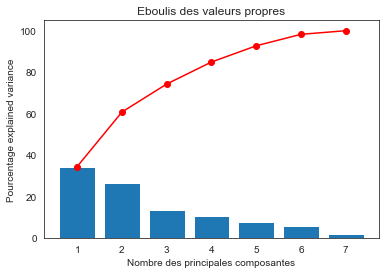

In [43]:
#Representation graphique des ratio de variances
display_scree_plot(pca) 

Les barres bleues montrent la variance en pourcentage expliquée par chaque composante principale (cela provient de pca.explained_variance_ratio_). La ligne rouge montre la somme cumulée (cela vient de pca.explained_variance_ratio_.cumsum()

À partir du diagramme d'éboulis, nous pouvons lire le pourcentage de la variance dans les données expliquées lorsque nous ajoutons des composants principaux. L'interpretation est la même que celle de la somme cumulée. Si nous voulions garder que 4 composants nous aurions plus de 80% des informations. Le but de l'ACP étant de réduire le nombre de valeurs, nous n'allons pas garder 100% des données.

In [44]:
#Definition des composantes principales
pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]
pc4 = pca.components_[3]

In [45]:
#Aperçu des colonnes du df pop_alim
pop_alim.columns

Index(['Pop 2017', 'Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité intérieure', 'Exportations - Quantité',
       'Importations - Quantité', 'PIB par habitant',
       'Stabilité politique et absence de violence/terrorisme'],
      dtype='object')

In [46]:
pc1 #on voit l'influence des colonnes et le score attribué à chaque colonne

array([0.16998553, 0.42922851, 0.50377743, 0.48172619, 0.27159126,
       0.393298  , 0.26938978])

In [47]:
pc2

array([ 0.46426596, -0.28354303,  0.40186609,  0.32060071, -0.06151977,
       -0.39244149, -0.53102193])

In [48]:
pc3

array([ 0.2220604 , -0.17575348, -0.10149213, -0.31667592,  0.86973937,
        0.13859505, -0.18319512])

In [49]:
pc4

array([ 0.77349933, -0.13899655, -0.10761151, -0.27813763, -0.32096637,
        0.30139759,  0.3155599 ])

###### Cercle de corrélation :  Mettre les scores des PC en cercles , pc1 avec pc2 et pc3 avec pc4

In [50]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)

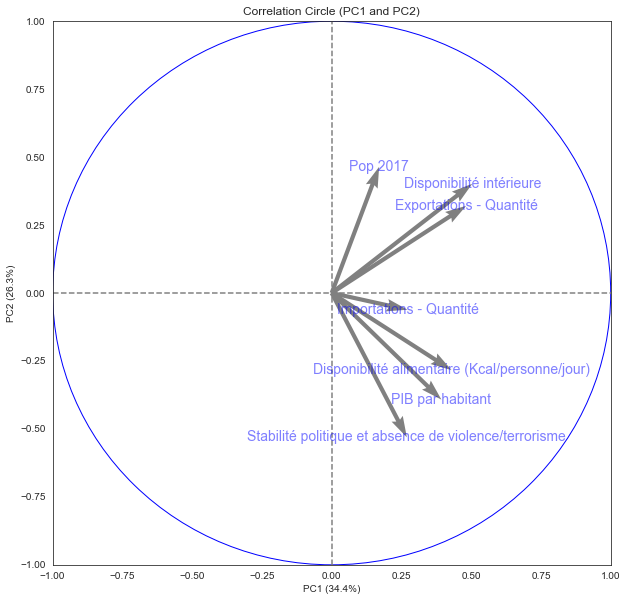

In [51]:
#Cercle des scores des composantes principales 1 et 2
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(0,1)], labels = np.array(pop_alim.columns),) 

Represente 60% des données, avec les composantes principales 1 & 2

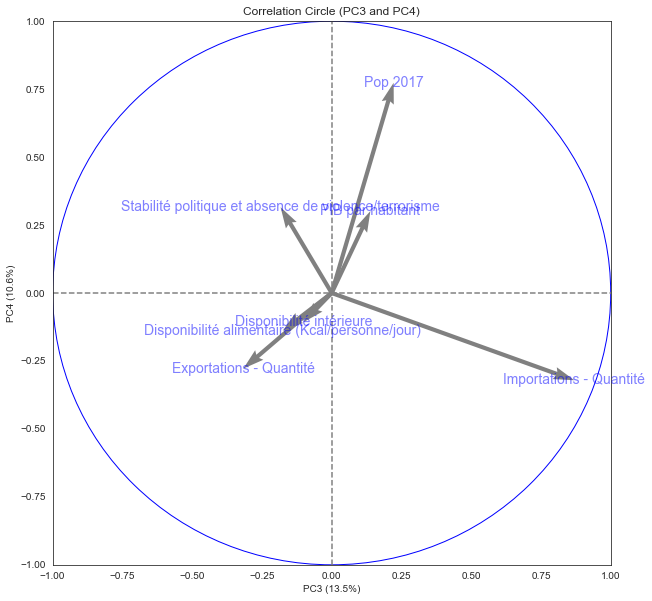

In [52]:
#Cercle des scores des composantes 2 et 3
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(2,3)], labels = np.array(pop_alim.columns),) 

Represente 23% des données, aves les composantes principales 2 et 3

On s'aperçoit que les 2 premières composantes, PC1 et PC 2 représente la santé économique, nutritionnelle et politique des pays.
On notera que les pays en positif dans PC1 auront un PIB par habitant plus élevé, une bonne stabilité politique ainsi qu'une bonne disponibilité alimentaire par habitant. 
Les pays en positif dans PC 2 ont une disponibilité intérieure importante ainsi qu'un volume élevé d'exportation avec une population conséquente. 
On remarquera aussi que PC 3 est intéressante puisqu'elle représente très fortement la quantité d'importation.

##### Afficher les données en points et les centroïdes sous forme de croix

In [53]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-5,5])
            plt.ylim([-5,5])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

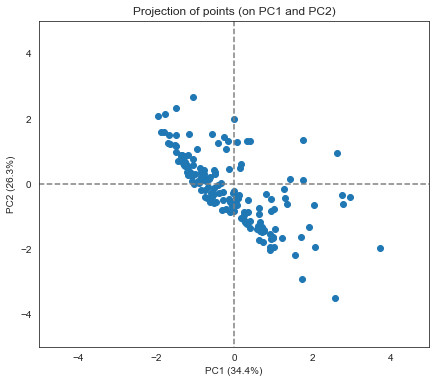

In [54]:
# Transform the original scaled data to the new vector space
X_projected = pca.transform(pop_alim2_scaled) 

# Display a scatter plot of the data points in this new vector space
display_factorial_planes(X_projected, num_components, pca, [(0,1)])

plt.show()



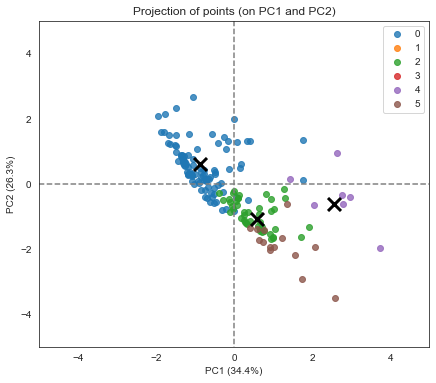

In [55]:
centroids = pca.transform(kmeans.cluster_centers_)
display_factorial_planes(X_projected, num_components, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)

##### Afficher les données en points et les centroïdes sous forme de croix

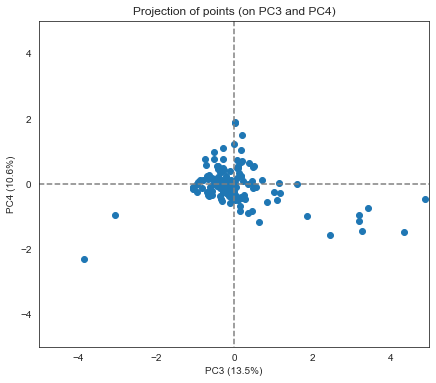

In [56]:
# Transform the original scaled data to the new vector space
X_projected = pca.transform(pop_alim2_scaled) 

# Display a scatter plot of the data points in this new vector space
display_factorial_planes(X_projected, num_components, pca, [(2,3)])
plt.show()

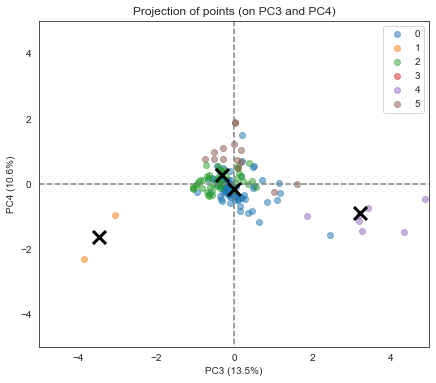

In [57]:
display_factorial_planes(X_projected, num_components, pca, [(2,3)], illustrative_var = clusters, alpha = 0.5)
plt.scatter(centroids[:, 2], centroids[:, 3],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)

### Conclusion générale :

Nous retrouvons des pays en communs entre la CAH et le kmeans , comme dit precedemment la composante géographique est une variable importante à prendre en compte 

Les pays que nous retrouvons en commun sont :
- la Belgique
- l'Autriche
- la Suisse 
- le Luxembourg
